In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using Plots
using ForwardDiff
using StaticArrays
using TrajectoryOptimization
using Altro
using RobotDynamics
using Colors
using CoordinateTransformations
using GeometryBasics
using MeshCat
using Rotations
using BenchmarkTools

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\Research notes\REx\TrajectoryOptimization.jl\examples\Hybrid Examples\Project.toml`
┌ Info: Precompiling TrajectoryOptimization [c79d492b-0548-5874-b488-5a62c1d9d0ca]
└ @ Base loading.jl:1278
┌ Info: Precompiling Altro [5dcf52e5-e2fb-48e0-b826-96f46d2e3e73]
└ @ Base loading.jl:1278
┌ Info: Precompiling CoordinateTransformations [150eb455-5306-5404-9cee-2592286d6298]
└ @ Base loading.jl:1278
┌ Info: Precompiling MeshCat [283c5d60-a78f-5afe-a0af-af636b173e11]
└ @ Base loading.jl:1278


## Quadruped

The quadruped is composed of four 3D hoppers, which were described in a prior example. Because each of the hopper's forces affect the body, we sum up the forces of each hopper's head in order to get the total forces on the body. Each hopper is assumed to be a prismatic joint and two revolute joints, allowing for yaw control of the foot. It makes the assumption that torque effects are equal and opposite at the head and foot. An image is shown below (copy that image in when you have time). It is parameterized by the following:  

$$ s = \begin{bmatrix} 
        \overrightarrow{r}_{body} \\
        \overrightarrow{q}_{body} \\
        \overrightarrow{r}_{f1} \\
        \overrightarrow{r}_{f2} \\
        \overrightarrow{r}_{f3} \\
        \overrightarrow{r}_{f4} \\
       \end{bmatrix} $$

where 
$$ \overrightarrow{r}_{body}  = \begin{bmatrix} 
                                  x_{body} \\
                                  y_{body} \\
                                  z_{body} \\
                                  \end{bmatrix}, \overrightarrow{q}_{body} = \begin{bmatrix} 
                                      q_{s} \\
                                      q_{x} \\
                                      q_{y} \\
                                      q_{z} \\
                                  \end{bmatrix}, \overrightarrow{r}_{fn}  = \begin{bmatrix} 
                                  x_{fn} \\
                                  y_{fn} \\
                                  z_{fn} \\
                                \end{bmatrix} $$
                         
Note that to account for the 3D rigid body orientation of the quadruped's body, we use a quaternion state. However, because the motion is always in 3D, we transform it back to 3 dimensions when calculating $\omega$. The details of the calculations can be found in the [Planning with Attitude](https://roboticexplorationlab.org/papers/planning_with_attitude.pdf) paper published by the REx Lab. For the dynamics, we refer to Section 2 of the paper for the following on rigid body dynamics:

$$ \dot{q} = \frac{1}{2}L(q)H\omega$$
$$L(q) = \begin{bmatrix} q_{s} & -q_{v}^{T} \\ q_{v} & q_{s}I + [q_{v}]^{\times} \end{bmatrix}$$

with $[q_{v}]^{\times}$ being the skew symmetric matrix of the vector $q_{v}$ detailed in the _skew_ function below. Combined, this forms a state vector of length 38 as 

$$ x = \begin{bmatrix}
          s \\
          \dot{s}\\
          \end{bmatrix}$$

Our control vector is length 24 and composed of the following:

$$ u = \begin{bmatrix}
         \overrightarrow{F}_{leg1}\\
         \overrightarrow{\lambda}_{leg1}\\
         \overrightarrow{F}_{leg2}\\
         \overrightarrow{\lambda}_{leg2}\\
         \overrightarrow{F}_{leg3}\\
         \overrightarrow{\lambda}_{leg3}\\
         \overrightarrow{F}_{leg4}\\
         \overrightarrow{\lambda}_{leg4}\\
       \end{bmatrix} $$ 
       
where
$$ \overrightarrow{F}_{leg} = \begin{bmatrix}
                                F_{pris} \\
                                F_{pitch} \\
                                F_{roll} \\
                              \end{bmatrix}, \overrightarrow{\lambda}_{legn} = \begin{bmatrix}
                                F_{xn, contact} \\
                                F_{yn, contact} \\
                                F_{zn, contact} 
                               \end{bmatrix}$$

For this model, the front left leg will be leg 1. The ordering will continue clockwise from there.




               

# TODO
## 1) Animate it! Check out the quadrotor exampels for meshcat, rotate vectors by quaternion (look at the Planning with Attitude)
## 2) LieState to trajopt the thing

In [2]:
# Reduced order quadruped, parameterized by the following:
struct quad_data
    mh::Float64
    mf::Float64
    states::Int64
    controls::Int64
    g::Float64
    l::Float64
    w::Float64
    h::Float64
end


function unpack_params()
    mh = 4.0
    mf = 1.0
    states = 37
    controls = 24
    g = 9.81
    l = 1.0 # length, x
    w = 0.5 # width, y
    h = 0.05 # thickness, z
    return quad_data(mh, mf, states, controls, g, l, w, h)
end


function skew(r)
    return [0    -r[3]  r[2];
            r[3]  0    -r[1];
           -r[2]  r[1]  0   ]
end

function q_prod(q, p)
    q0 = q[1]
    qv = q[2:4]
    if length(p) < 4
        p0 = 0.0
        pv = p[1:3]
    else
        p0 = p[1]
        pv = p[2:4]
    end
    
    return [q0*p0 - dot(qv, pv); q0.*pv .+ p0*qv .+ cross(qv, pv)]
end


function conj_q(q)
    return [q[1]; -q[2:4]]
end
    

function quat_deriv(q, ω)
    ωspec = q_prod(q_prod(conj_q(q), ω), q)
    return 1/2 * q_prod(q, ωspec)
end

quat_deriv (generic function with 1 method)

In [10]:
# Dynamics functions
function dynamics_3d(x, u)
    # x is a 37-dimensional vector, u is a 24-dimensional vector
    qd = unpack_params()
    
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    states = qd.states
    controls = qd.controls
    
    q = UnitQuaternion(x[4:7], true)
    ω = x[23:25]
    
    xdot = zeros(states)
    xdot[1:3] .= x[20:22]
    xdot[4:7] .= Rotations.kinematics(q, ω)
    xdot[8:19] .= x[26:states]
    
    comVec = x[1:3]
    
    # To get this into a matrix, we have to look at the standard Euler-Lagrange equations:
    # The mass matrix is just diagonals of the masses
    # The coriolis term is 0 everywhere except for the body thing, which is just ω x inertial matrix * ω
    # The adding term is [0;0;-mg; ... etc] for each thing with a force
    # The B matrix is going to be: 
    #          first "row" is all 6x6 [I, 0s; 0s, 0s]s, since want to sum up the forces 
    #          second "row" is the 3x3 skew symmetric vectors representing r from COM to foot
    #          rest of the rows are [-Is, 0s; 0s, 0s] since we want to add the contact forces and subtract the joints
    # The J Matrix is going to be 0s for the first two rows, then 6x6 [0s, 0s; 0s, Is] to isolate the contact forces
    # 
    
    Ixx = w^2 + h^2
    Iyy = l^2 + h^2
    Izz = l^2 + w^2
    inertial_matrix = SMatrix{3, 3}(m/3 * diagm([Ixx, Iyy, Izz]))
    cori = cross(ω, inertial_matrix * ω)
    
    z3 = zeros(3, 3)
    M = SMatrix{18, 18, Float64}(diagm([mh, mh, mh, Ixx, Iyy, Izz, mf, mf, mf, mf, mf, mf, mf, mf, mf, mf, mf, mf]))
    c = @SVector [0.0, 0.0, -mh*g, -cori[1], -cori[2], -cori[3], 0.0, 0.0, -mf*g, 0.0, 0.0, -mf*g, 0.0, 0.0, -mf*g, 0, 0, -mf*g]
    # println(size(C))
    
    r1 = comVec .- x[8:10]
    r2 = comVec .- x[11:13]
    r3 = comVec .- x[14:16]
    r4 = comVec .- x[17:19]
    # Because the contact forces and controls are wrapped up, we just add them together while we're here
    B = SMatrix{18, 24}([I  z3        I  z3       I  z3       I  z3;
                         skew(r1) z3  skew(r2) z3 skew(r3) z3 skew(r4) z3;
                         -I I         z3 z3       z3 z3       z3 z3;
                         z3 z3        -I I        z3 z3       z3 z3;
                         z3 z3        z3 z3       -I I        z3 z3;
                         z3 z3        z3 z3       z3 z3       -I I ])
    dv = M \ (c + B*u)
    xdot[20:states] .= dv
    return xdot
end


# function dynamics_3d_ns(x, u)
#     # x is a 12-dimensional vector, u is a 6-dimensional vector
#     qd = unpack_params()
    
#     mh = qd.mh
#     mf = qd.mf
#     l = qd.l
#     w = qd.w
#     h = qd.h
#     g = qd.g
    
#     states = qd.states
#     controls = qd.controls
    
#     v = x[19:states]
#     ω = v[4:6]
#     comVec = x[1:3]
    
#     # To get this into a matrix, we have to look at the standard Euler-Lagrange equations:
#     # The mass matrix is just diagonals of the masses
#     # The coriolis term is 0 everywhere except for the body thing, which is just ω x inertial matrix * ω
#     # The adding term is [0;0;-mg; ... etc] for each thing with a force
#     # The B matrix is going to be: 
#     #          first "row" is all 6x6 [I, 0s; 0s, 0s]s, since want to sum up the forces 
#     #          second "row" is the 3x3 skew symmetric vectors representing r from COM to foot
#     #          rest of the rows are [-Is, 0s; 0s, 0s] since we want to add the contact forces and subtract the joints
#     # The J Matrix is going to be 0s for the first two rows, then 6x6 [0s, 0s; 0s, Is] to isolate the contact forces
#     # 
    
#     Ixx = w^2 + h^2
#     Iyy = l^2 + h^2
#     Izz = l^2 + w^2
#     inertial_matrix = m/3 * diagm([Ixx, Iyy, Izz])
    
#     z3 = zeros(3, 3)
#     M = diagm([mh, mh, mh, Ixx, Iyy, Izz, mf, mf, mf, mf, mf, mf, mf, mf, mf, mf, mf, mf]);
#     c = [0.0, 0.0, -mh*g, 0.0, 0.0, 0.0, 0.0, 0.0, -mf*g, 0.0, 0.0, -mf*g, 0.0, 0.0, -mf*g, 0, 0, -mf*g]
#     C = [zeros(3); cross(ω, inertial_matrix * ω); zeros(12)]
    
#     r1 = comVec .- x[7:9]
#     r2 = comVec .- x[10:12]
#     r3 = comVec .- x[13:15]
#     r4 = comVec .- x[16:18]
#     # Because the contact forces and controls are wrapped up, we just add them together while we're here
#     B = [I  z3       I  z3       I  z3       I  z3;
#                         z3 skew(r1) z3 skew(r2) z3 skew(r3) z3 skew(r4);
#                         -I I        z3 z3       z3 z3       z3 z3;
#                         z3 z3       -I I        z3 z3       z3 z3;
#                         z3 z3       z3 z3       -I I        z3 z3;
#                         z3 z3       z3 z3       z3 z3       -I I ]
#     dv = M \ (c + B*u - C)
#     return [v; dv]
# end


function dynamics_3d_rk4(x, u, h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics_3d(x, u)
    f2 = dynamics_3d(x + 0.5*h*f1, u)
    f3 = dynamics_3d(x + 0.5*h*f2, u)
    f4 = dynamics_3d(x + h*f3, u)
    return SVector{37, Float64}(x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4))
end


function dynamics_3d_rk4_ns(x, u, h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics_3d_ns(x, u)
    f2 = dynamics_3d_ns(x + 0.5*h*f1, u)
    f3 = dynamics_3d_ns(x + 0.5*h*f2, u)
    f4 = dynamics_3d_ns(x + h*f3, u)
    return SVector{36, Float64}(x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4))
end


struct SimpleQuad <: AbstractModel end
RobotDynamics.state_dim(::SimpleQuad) = 37
RobotDynamics.control_dim(::SimpleQuad) = 24


function RobotDynamics.dynamics(::SimpleQuad,x,u)
    ẋ = dynamics_3d(x, u)
end


# Convert from quaternion to other parameter representations
function q2angleaxis(q)
    qs = q[1]
    qv = q[2:4]
    ϵ = 0.005
    nm = norm(qv)
    
    if nm < ϵ 
        return [zeros(3); 1.0]
    end
    
    #println(nm/qs)
    θ = 2 * atan(nm, qs)
    axis = qv ./ nm
    return θ, axis[1], axis[2], axis[3]
end


function q2taitbryan(q)
    w = q[1]
    x = q[2]
    y = q[3]
    z = q[4]
    yaw = angle(2.0*(y*z + w*x) / w*w - x*x - y*y + z*z);
    pitch = asin(-2.0*(x*z - w*y));
    roll = angle(2.0*(x*y + w*z) / w*w + x*x - y*y - z*z);
    return roll, pitch, yaw
end
    

q2taitbryan (generic function with 1 method)

In [25]:
# Dynamics test
begin
    model = SimpleQuad()
    m = state_dim(model)
    n = control_dim(model)
    ts = 100
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    dt = 0.01

    q = [0.0; 0.0; 0.5; 1.0; 0.0; 0.0; 0.0; l/2; -w/2; 0.0; l/2; w/2; 0.0; -l/2; w/2; 0.0; -l/2; -w/2; 0.0]
    x = SVector{m, Float64}([q; zeros(18)])
    ftF = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    backFt = [0.0; 0.0; mh/5*g; 0.0; 0.0; (mh/5+mf)*g]
    u = SVector{24, Float64}([ftF; backFt; backFt; ftF;])
    # u = SVector{24, Float64}([ftF; ftF; ftF; ftF])
#     for i = 1:5
#         x .= dynamics_3d_rk4(x, u, h)
#     end
#     println(x)
    xarr = []
    H = [0.0 0.0 0.0; I(3)]
    for i = 1:ts
        push!(xarr, x)
        quat = x[4:7]
        dx = dynamics_3d(x, u)
        x = dynamics_3d_rk4(x, u, dt)
        θ, roll, pit, yaw = q2angleaxis(quat)
#         println("Quat: ", quat)
#         println("Angles around x, y, z axis :", roll, " ", pit, " ", yaw)
#         println("x, y, z: ", x[1:3])
    end
    # @btime dynamics_3d_rk4_ns(x, u, h)
    # println(xarr[1])
    # println(typeof(xarr))
    # println(xarr)
    visualize!(vis, xarr, dt)
    # println(xarr[100])
    # plot(xarr, inds=8:10)
    # println(xarr[100][11:13])
    # @code_warntype dynamics_3d(x, u)
end

##  Visualizer
We initialize the visualizer below

In [12]:
function kinematics(x)
    return [x[1], x[2]]
end

function set_mesh!(vis, initState)
    qd = unpack_params()
    r_foot = 0.05
    bodyFL = Vec(0.0, 0.0, 0.0)
    bodyBR = Vec(qd.l, qd.w, qd.h)
    init_loc = 1/2 * [qd.l, qd.w, qd.h] 
    
    footSphere = Sphere(Point3f0(0), convert(Float32, r_foot))
    bodyRect = HyperRectangle(bodyFL, bodyBR)
    setvisible!(vis["/Background"], true)
    setobject!(vis["f1"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    setobject!(vis["f2"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    setobject!(vis["f3"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    setobject!(vis["f4"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    setobject!(vis["body"], bodyRect, MeshPhongMaterial(color = RGBA(0.5, 0.5, 0.5, 1.0)))
    z_shift = [0.0, 0.0, r_foot/2]
    # body_shift = initState[1:3]
    
    settransform!(vis["f1"], Translation(initState[8:10] + z_shift))
    settransform!(vis["f2"], Translation(initState[11:13] + z_shift))
    settransform!(vis["f3"], Translation(initState[14:16] + z_shift))
    settransform!(vis["f4"], Translation(initState[17:19] + z_shift))
    settransform!(vis["body"], Translation(initState[1:3] - init_loc))
end
    

function visualize!(vis, Xs, h)
    set_mesh!(vis, Xs[1])
    anim = MeshCat.Animation(convert(Int, floor(1.0 / h)))
    r_foot = 0.05
    for t = 1:length(Xs)
        x = Xs[t]
        p_body = x[1:3]
        q = x[4:7]
        angs = q2angleaxis(q)
        p_f1 = x[8:10]
        p_f2 = x[11:13]
        p_f3 = x[14:16]
        p_f4 = x[17:19]
        
        z_shift = [0.0, 0.0, r_foot]
        qd = unpack_params()
        b_shift = 1/2 * [-qd.l, -qd.w, 0.0] 
        # body_shift = [0.0, 0.0, r_foot]  
        
        MeshCat.atframe(anim, t) do 
            H = compose(Translation(p_body + b_shift), LinearMap(AngleAxis(angs[1], angs[2], angs[3], angs[4])))
            settransform!(vis["body"], H)
            settransform!(vis["f1"], Translation(p_f1 + z_shift))
            settransform!(vis["f2"], Translation(p_f2 + z_shift))
            settransform!(vis["f3"], Translation(p_f3 + z_shift))
            settransform!(vis["f4"], Translation(p_f4 + z_shift))
        end
        
    end
    MeshCat.setanimation!(vis, anim)
    
end
            

visualize! (generic function with 1 method)

In [5]:
# Initialize the visualizer
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [6]:
bcd = unpack_params()
set_mesh!(vis, [0.0; 0.0; 0.5; 1.0; 0.0; 0.0; 0.0; bcd.l/2; -bcd.w/2; 0.0; bcd.l/2; bcd.w/2; 0.0; -bcd.l/2; bcd.w/2; 0.0; -bcd.l/2; -bcd.w/2; 0.0])

MeshCat Visualizer with path /meshcat/body at http://127.0.0.1:8700

In [4]:
# Pass in an array which determines what foots are in stance phase
# Feet are labelled by 1, 2, 3, 4 in the array.

function stance_constraints_quad(model, feet)
    n = state_dim(model)
    m = control_dim(model)
    rows = length(feet)
    A = zeros(rows*3, n)
    # Pin the foot to the floor, so no velocity in any direction
    # Transform indices:
    #       z indices: 9, 12, 15, 18
    #       dx indices: 25, 28, 31, 34
    #       dy indices: 26, 29, 32, 35
    zInds = 3 * feet .+ 6
    dxInds = 3 * feet .+ 22
    dyInds = 3 * feet .+ 23
    count = 1
    for i = 1:rows
        A[count, zInds[i]] = 1.0
        count += 1
        A[count, dxInds[i]] = 1.0
        count += 1
        A[count, dyInds[i]] = 1.0
        count += 1
    end
    b = SVector{rows*3}(zeros(rows*3))
    return LinearConstraint(n, m, A, b, Equality(), 1:n)
end


function flight_constraints_quad(model, feet)
    n = state_dim(model)
    m = control_dim(model)
    rows = length(feet)
    A = zeros(rows*3, m)
    # Constrain the contact forces to be 0
    # Transform indices: 4 5 6, 10 11 12, 16 17 18, 22 23 24
    count = 1
    λxInds = 6 * feet .- 2
    λyInds = 6 * feet .- 1
    λzInds = 6 * feet
    for i = 1:rows
        A[count, λxInds[i]] = 1.0
        count += 1
        A[count, λyInds[i]] = 1.0
        count += 1
        A[count, λzInds[i]] = 1.0
        count += 1
    end
    b = SVector{rows*3}(zeros(rows*3))
    return LinearConstraint(n, m, A, b, Equality(), (n+1):(n+m))
end


# function friction_constraints_3d(model)
#     n = state_dim(model)
#     m = control_dim(model)
#     A = zeros(1, m)
#     μ = 0.5
#     A[1, 3] = 1.0
#     A[1, 4] = -μ
#     b = SVector{1}(0.0)
#     forward = LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
    
#     A = zeros(1, m)
#     μ = 0.5
#     A[1, 3] = -1.0
#     A[1, 4] = -μ
#     b = SVector{1}(0.0)
#     backward = LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
#     return forward, backward
# end

# Control input, makes sure z contact is going upwards
function normal_constraints_quad(model)
    n = state_dim(model)
    m = control_dim(model)
    A = zeros(4, m)
    A[1, 6] = -1.0
    A[2, 12] = -1.0
    A[3, 18] = -1.0
    A[4, 24] = -1.0
    b = SVector{4}(zeros(4))
    return LinearConstraint(n, m, A, b, Inequality(), (n+1):(n+m))
end


function bin_mode_list(N, mSteps; iState=1)
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    return modeList
end

function add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    for i = 1:(length(modeList)-1)
        add_constraint!(conSet, forward, i)
        add_constraint!(conSet, backward, i)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
end

function add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    for i = 1:(length(modeList)-1)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
end

add_nf_constraints! (generic function with 1 method)

## Jump straight up

SArray{Tuple{36},Float64,1,36}

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 17
    Solve Time: 1023.0596009999999 (ms)

  Covergence
    Terminal Cost: 7465.8867907593985
    Terminal dJ: -0.019514538240400725
    Terminal gradient: 149.91898955433086
    Terminal constraint violation: 2.8554220997457393e-5
    Solve Status: SOLVE_SUCCEEDED
SArray{Tuple{24},Float64,1,24}[[1.1357581843637043e-16, 4.552865375406393e-18, 9.398602541687467, 1.0777690961153925e-16, 6.127385825522727e-18, 19.171353370333907, 1.1336159901945353e-16, 4.710756896985527e-18, 9.398602541687469, 1.0769047496867286e-16, 5.9646669961647696e-18, 19.171353370333907, 1.1336296980690212e-16, 4.040857622354352e-18, 9.398602541687465, 1.0769004838727047e-16, 6.031882927018374e-18, 19.171353370333904, 1.1355271836732041e-16, 3.899399792979711e-18, 9.398602541687463, 1.07799888108

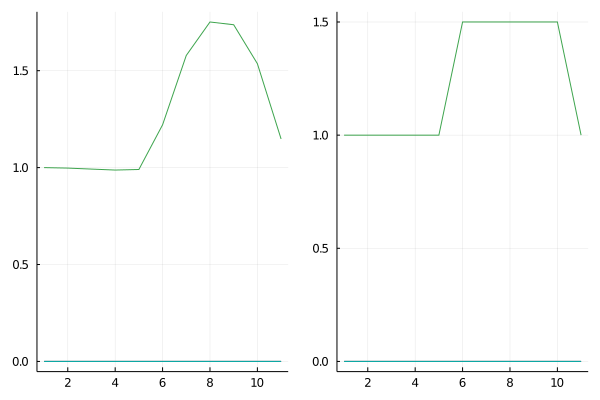

In [117]:
begin
    model = SimpleQuad()
    n = state_dim(model)
    m = control_dim(model)
    
    qd = unpack_params()
    mh = qd.mh
    mf = qd.mf
    l = qd.l
    w = qd.w
    h = qd.h
    g = qd.g
    
    q = [0.0; 0.0; 1.0; 0.0; 0.0; 0.0; l/2; -w/2; 0.0; l/2; w/2; 0.0; -l/2; w/2; 0.0; -l/2; -w/2; 0.0]
    currX = [q; zeros(18)]
    ftF = [0.0; 0.0; mh/4*g; 0.0; 0.0; (mh/4+mf)*g]
    backFt = [0.0; 0.0; 0.0; 0.0; 0.0; mf*g]
    ueq = [ftF; ftF; ftF; ftF]
    
    N = 11
    dt = 0.1
    mSteps = 5
    modeList = bin_mode_list(N, mSteps)
    
    # costInit = Diagonal([5.0, 5.0, 20.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    Q = 2000.0 * I(n) # diagm([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    Qf = 200.0 * I(n)
    R = 0.1 * I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    
    for i = 2:N
        xRefSimp[:, i] .= currX
        if modeList[i] == 2
            xRefSimp[3, i] = 1.5
            xRefSimp[9, i] = 0.5
            xRefSimp[12, i] = 0.5
            xRefSimp[15, i] = 0.5
            xRefSimp[18, i] = 0.5
        end
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    println(typeof(dynamics_3d_rk4(XRefSimp[1], ueq, 0.1)))
    
    # Stance constraints
    feet = [1, 2, 3, 4]
    stnc = stance_constraints_quad(model, feet)
    flgt = flight_constraints_quad(model, feet)
    # forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_quad(model)
    
    add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:6)
    p2 = plot(XRefSimp, inds=1:6)
    println(solveU)
    # visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2), legend=false)
end

## Circle hops

In [ ]:
begin
    model = Hopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 102
    h = 0.1
    mSteps = 5
    modeList = bin_mode_list(N, mSteps)
    
    g = 9.81
    ueq = [g, 0.0, 0.0, 0.0, 0.0, 2*g]
    
    
    # costInit = Diagonal([5.0, 5.0, 20.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    Q = 100.0 * diagm([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    Qf = 200.0 * I(n)
    R = 0.1 * I(m)
    
    
    # Follow the path of a circle with a certain radius
    r = 1.6
    # equation of a circle is x^2 + y^2 = r^2, so let our dx = 0.1
    currX = zeros(n)
    currX[3] = 1.0
    currX[1] = r
    currX[4] = r
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    for i = 2:N
        if modeList[i] == 1
            xRefSimp[3, i] = 1.0
            xRefSimp[6, i] = 0.0
        else
            xRefSimp[3, i] = 1.5
            xRefSimp[6, i] = 0.5
        end 
        xRefSimp[1, i] = r*cos(2*pi/N * (i-1))
        xRefSimp[4, i] = r*cos(2*pi/N * (i-1))
        xRefSimp[2, i] = r*sin(2*pi/N * (i-1))
        xRefSimp[5, i] = r*sin(2*pi/N * (i-1))
    end
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    # println(dynamics_3d_rk4(XRefSimp[1], ueq, 0.1))
    
    # Stance constraints
    stnc = stance_constraints_3d(model)
    flgt = flight_constraints_3d(model)
    # forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_3d(model)
    
    add_nf_constraints!(conSet, stnc, flgt, normal, modeList)
    
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:6)
    p2 = plot(XRefSimp, inds=1:6)
    # println(solveU)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2), legend=false)
end

## Back and forth hopping

In [ ]:
function step_constraints_3d(model)
    n = state_dim(model)
    m = control_dim(model)
    rows = 3
    A = zeros(rows, n)
    # Pin the foot to the floor, so no velocity in any direction
    # A[1, 6] = 1.0
    A[1, 10] = 1.0
    A[2, 11] = 1.0
    A[3, 12] = 1.0
    b = SVector{rows}(zeros(rows))
    return LinearConstraint(n, m, A, b, Equality(), 1:n)
end

function add_step_constraints!(conSet, stnc, flgt, step, normal, modeList)
    for i = 1:(length(modeList)-1)
        add_constraint!(conSet, normal, i)
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        elseif modeList[i] == 2
            add_constraint!(conSet, flgt, i)
        else
            add_constraint!(conSet, step, i)
        end
    end
end

In [ ]:
begin
    model = Hopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 55
    h = 0.1
    mSteps = 5
    modeList = bin_mode_list(N, mSteps)
    modeList[end-mSteps+1:end] .= 3
    
    g = 9.81
    ueq = [g, 0.0, 0.0, 0.0, 0.0, 2*g]
    currX = zeros(n)
    currX[3] = 1.0
    
    # costInit = Diagonal([5.0, 5.0, 20.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    Q = 200.0 * diagm([1.0, 5.0, 5.0, 1.0, 5.0, 20.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    Qf = 100.0 * I(n)
    R = 0.1 * I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] = currX
    
    xShift = 0.0
    yShift = 0.1
    
    for i = 2:N
        if modeList[i] == 1
            xRefSimp[3, i] = 1.0
            xRefSimp[6, i] = 0.0
            xRefSimp[1, i] = xRefSimp[1, i-1]
            xRefSimp[4, i] = xRefSimp[4, i-1]
            xRefSimp[2, i] = xRefSimp[2, i-1]
            xRefSimp[5, i] = xRefSimp[5, i-1]
        elseif modeList[i] == 2
            xRefSimp[3, i] = 1.5
            xRefSimp[6, i] = 0.5
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[5, i] = xRefSimp[5, i-1] + yShift
        else
            xRefSimp[3, i] = 1.5
            xRefSimp[6, i] = 0.5
            xRefSimp[1, i] = xRefSimp[1, i-1]
            xRefSimp[4, i] = xRefSimp[4, i-1]
            xRefSimp[2, i] = xRefSimp[2, i-1]
            xRefSimp[5, i] = xRefSimp[5, i-1]
        end 
    end
#     xRefSimp[3, end-2*mSteps+1:end] .= 4.5
#     xRefSimp[6, end-2*mSteps+1:end] .= 3.5
    println(xRefSimp[2, :])
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    conSet = ConstraintList(n, m, N)
    
    # println(dynamics_3d_rk4(XRefSimp[1], ueq, 0.1))
    
    # Stance constraints
    stnc = stance_constraints_3d(model)
    flgt = flight_constraints_3d(model)
    # forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_3d(model)
    
    add_step_constraints!(conSet, stnc, flgt, step, normal, modeList)
    step = step_constraints_3d(model)
    
    
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:6)
    p2 = plot(XRefSimp, inds=1:6)
    println(modeList)
    box = HyperRectangle(Vec(-0.5, 2.15, 0.0), Vec(1.0, 1.0, 0.5))
    green_material = MeshPhongMaterial(color=RGBA(1, 1, 1, 1.0))
    setobject!(vis, box, green_material)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2), legend=false)
end

## Backflip

In [ ]:
begin
    model = ExtraHopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 15
    st = 13
    h = 0.1
    mSteps = N
      
    modeList = ones(1, N) * 2.0
    modeList[1] = 1.0
    # modeList[end] = 1.0
    modeList[st:N] .= 1.0
    
    g = 9.81
    ueq = [g, 0.0, 0.0, 2*g]
    currX = [0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Create the cost
    Q = 50.0 * Diagonal([5.0, 5.0, 5.0, 2.0, 1.0, 1.0, 1.0, 1.0])
    
    Qf = 500.0 * Diagonal([5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])

    R = 0.1* I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] .= currX
    uRefSimp = zeros(m, N-1)
    
    xShift = 0.75
    yShift = 0.01
    for i = 2:N
        if i-1 <= st/4
            xRefSimp[3, i] = xRefSimp[3, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] - xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
            xRefSimp[5, i] = -xShift
            xRefSimp[6, i] = yShift
            xRefSimp[7, i] = xShift
            xRefSimp[8, i] = xShift
        elseif i-1 > st/4 && i-1 <= st/2
            xRefSimp[3, i] = xRefSimp[3, i-1] - xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
            xRefSimp[5, i] = xShift
            xRefSimp[6, i] = yShift
            xRefSimp[7, i] = -xShift
            xRefSimp[8, i] = xShift
        elseif i-1 > st/2 && i-1 <= 3*st/4
            xRefSimp[3, i] = xRefSimp[3, i-1] - xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] - yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] - xShift
            xRefSimp[5, i] = xShift
            xRefSimp[6, i] = -yShift
            xRefSimp[7, i] = -xShift
            xRefSimp[8, i] = -xShift
        elseif i-1 > 3*st/4 && i-1 <= st
            xRefSimp[3, i] = xRefSimp[3, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] - yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] - xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] - xShift
            xRefSimp[5, i] = -xShift
            xRefSimp[6, i] = -yShift
            xRefSimp[7, i] = xShift
            xRefSimp[8, i] = -xShift
        end
    end
    
    xRefSimp[:, st:end] .= currX

    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    # Add in the constraints
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    stnc = stance_constraints_2d(model)
    
    # Flight constraints
    flgt = flight_constraints_2d(model)
    forward, backward = friction_constraints_2d(model)
    normal = normal_constraints_2d(model)
    
    add_all_constraints!(conSet, stnc, flgt, forward, backward, normal, modeList)
    
    
    # Solve ALTRO
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:4)
    p2 = plot(XRefSimp, inds=1:4)
    visualize!(vis, solveX, h)
    println(solveU)
    plot(p1, p2, layout = (1, 2))
    # plot(XRefSimp, inds=1:4)
end